**LIBRARIES AND CONFIGURATION**

In [28]:
import os
import re
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import folium
from folium.plugins import MarkerCluster

# Configure environment
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')

class Config:
    DATA_PATH = '/kaggle/input/soil-distribution/model_training_img'
    PHASE1_SIZE = 160
    PHASE2_SIZE = 224
    BATCH_SIZE = 48
    FINE_TUNE_BATCH_SIZE = 24
    MIN_SAMPLES = 40
    EPOCHS_HEAD = 12
    EPOCHS_FINE = 15
    MAP_ZOOM = 5

config = Config()

**DATA LOADING AND PREPARATION**

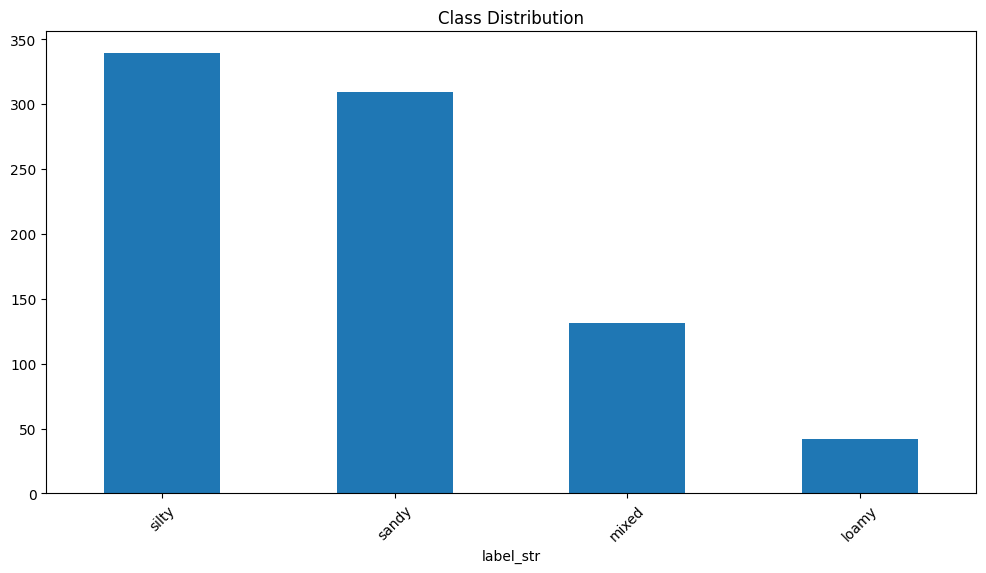

In [16]:
def load_and_prepare_data(config):
    p = Path(config.DATA_PATH)
    files = list(p.glob('**/*.jpg')) + list(p.glob('**/*.jpeg')) + list(p.glob('**/*.JPG'))
    
    records = []
    coord_pattern = re.compile(r'(-?\d+\.\d+)_(-?\d+\.\d+)')
    
    for fp in files:
        parts = fp.stem.split('_')
        try:
            # Extract coordinates from filename
            coord_match = coord_pattern.search(fp.stem)
            if not coord_match:
                continue
            lat, lon = map(float, coord_match.groups())
            
            # Extract texture label
            texture_idx = parts.index("texture")
            label = '_'.join(parts[texture_idx+1:]).lower()
            
            records.append({
                'filepath': str(fp),
                'label_str': label,
                'latitude': lat,
                'longitude': lon
            })
        except (ValueError, IndexError):
            continue

    df = pd.DataFrame(records)
    
    # Class consolidation
    consolidation_map = {
        'loamy_sand': 'sandy', 'sandy': 'sandy', 'silty_sand': 'sandy',
        'sandy_silt': 'sandy', 'combined_loamy_sand_sandy_loam': 'sandy',
        'loamy_silt': 'silty', 'clay_silt': 'silty', 
        'combined_loamy_silt_silty_loam': 'silty',
        'clay_loam': 'clay', 'clay_soil': 'clay',
        'combined_clay_loam_loamy_clay': 'clay',
        'complex_mixes': 'mixed', 'loamy_silty_sand': 'mixed',
        'silty_loamy_sand': 'mixed', 'clay_sand': 'mixed',
        'clay_silty_sand': 'mixed', 'loamy_clay_sand': 'mixed',
        'loamy_soil': 'loamy'
    }
    
    df['label_str'] = df['label_str'].map(consolidation_map).fillna('other')
    df = df[df['label_str'].isin(consolidation_map.values())]
    
    # Filter classes
    counts = df['label_str'].value_counts()
    df = df[df['label_str'].isin(counts[counts >= config.MIN_SAMPLES].index)]
    
    # Encode labels
    df['label'] = pd.Categorical(df['label_str']).codes
    label_map = dict(enumerate(df['label_str'].astype('category').cat.categories))
    
    # Plot class distribution
    plt.figure(figsize=(12,6))
    df['label_str'].value_counts().plot(kind='bar')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()
    
    return df.reset_index(drop=True), label_map

df, label_map = load_and_prepare_data(config)

**VISUALISING SOIL LOCATION**

In [17]:
def plot_soil_locations(df, label_map, zoom=5):
    print("\nGenerating geographical distribution map...")
    
    color_mapping = {
        'sandy': 'orange',
        'silty': 'blue',
        'clay': 'red',
        'loamy': 'green',
        'mixed': 'purple',
        'other': 'gray'
    }
    
    # Create base map
    m = folium.Map(
        location=[df['latitude'].mean(), df['longitude'].mean()],
        zoom_start=zoom,
        tiles='CartoDB positron'
    )
    
    # Add clustered markers
    marker_cluster = MarkerCluster().add_to(m)
    
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color=color_mapping.get(row['label_str'], 'gray'),
            fill=True,
            fill_color=color_mapping.get(row['label_str'], 'gray'),
            popup=f"{row['label_str']}",
            tooltip=f"Coordinates: {row['latitude']:.4f}, {row['longitude']:.4f}"
        ).add_to(marker_cluster)
    
    # Save and display
    m.save('soil_distribution_map.html')
    display(m)
    print("Map saved as soil_distribution_map.html")


plot_soil_locations(df, label_map, config.MAP_ZOOM)



Generating geographical distribution map...


Map saved as soil_distribution_map.html


**DATA PIPELINE**

In [27]:
class DataPipeline:
    def __init__(self, config):
        self.config = config
        self.augment = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.25),
            layers.RandomContrast(0.2),
            layers.GaussianNoise(0.01),
            layers.RandomBrightness(0.1)
        ])
        
    def _process_image(self, path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, label

    def create_dataset(self, df, img_size, augment=False, fine_tune=False):
        ds = tf.data.Dataset.from_tensor_slices((df['filepath'], df['label']))
        ds = ds.map(self._process_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        if augment:
            ds = ds.map(
                lambda x, y: (self.augment(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )
            
        ds = ds.map(
            lambda x, y: (
                applications.efficientnet.preprocess_input(
                    tf.image.resize(x, [img_size, img_size])
                ),
                y
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        batch_size = self.config.FINE_TUNE_BATCH_SIZE if fine_tune else self.config.BATCH_SIZE
        return ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


dp = DataPipeline(config)


**MODEL ARCHITECTURE**

In [19]:
def build_base_model(input_size, num_classes):
    base_model = applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_shape=(input_size, input_size, 3),
        pooling='avg'
    )
    base_model.trainable = False
    
    inputs = layers.Input(shape=(input_size, input_size, 3))
    x = base_model(inputs)
    x = layers.Dense(384, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(inputs, outputs)

def create_fine_tune_model(base_model, num_classes):
    base_model.trainable = True
    # Freeze initial layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    # Add new top layers
    x = base_model.output
    x = layers.Dense(192, activation='swish')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(base_model.input, outputs)

**DATA SPLITTING**

In [20]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
val_df, test_df = train_test_split(val_df, test_size=0.3, stratify=val_df['label'])

**PHASE ONE: BASE MODEL TRAINING**

In [24]:
if 'phase1_model' not in locals():  # Only run if not already trained
    train_ds = dp.create_dataset(train_df, config.PHASE1_SIZE, augment=True)
    val_ds = dp.create_dataset(val_df, config.PHASE1_SIZE)
    
    phase1_model = build_base_model(config.PHASE1_SIZE, len(label_map))
    phase1_model.compile(
        optimizer=optimizers.AdamW(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    phase1_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.EPOCHS_HEAD,
        callbacks=[
            callbacks.EarlyStopping(patience=2, restore_best_weights=True),
            callbacks.ModelCheckpoint('phase1.keras', save_best_only=True, save_weights_only=False)
        ]
    )

**PHASE 2: FINE TUNING**

In [25]:
# ─── Phase 2: Revised Fine-Tuning Implementation ────────────────────────────
print("\n=== Phase 2: Optimized Fine-Tuning (Revised Approach) ===")

# 1. Load phase1 model components
print("Loading phase1 model components...")
phase1_model = build_base_model(config.PHASE1_SIZE, len(label_map))
phase1_model.load_weights('phase1.keras')

# 2. Create new base model with proper initialization
print("Building phase2 base model...")
base_model = applications.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(config.PHASE2_SIZE, config.PHASE2_SIZE, 3),
    pooling='avg'
)

# 3. Build hybrid model with transferred top layers
print("Constructing hybrid model architecture...")

# Get trainable components from phase1
phase1_dense_weights = phase1_model.layers[-3].get_weights()  # First dense layer
phase1_output_weights = phase1_model.layers[-1].get_weights()  # Output layer

# Build new model architecture
inputs = layers.Input(shape=(config.PHASE2_SIZE, config.PHASE2_SIZE, 3))
x = base_model(inputs)
x = layers.Dense(256, activation='swish',
                kernel_initializer=tf.constant_initializer(phase1_dense_weights[0]),
                bias_initializer=tf.constant_initializer(phase1_dense_weights[1]))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(label_map), activation='softmax',
                      kernel_initializer=tf.constant_initializer(phase1_output_weights[0]),
                      bias_initializer=tf.constant_initializer(phase1_output_weights[1]),
                      dtype='float32')(x)

model = models.Model(inputs, outputs)

# 4. Configure layer trainability
# Freeze entire base model initially
base_model.trainable = False

# Unfreeze last 5 blocks gradually
unfreeze_blocks = ['block7a', 'block7b', 'top']
for layer in base_model.layers:
    if any(block in layer.name for block in unfreeze_blocks):
        layer.trainable = True

# 5. Compile with lower learning rate
model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-6, global_clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Memory-optimized data pipeline
train_ds_ft = dp.create_dataset(train_df, config.PHASE2_SIZE, 
                               augment=True, fine_tune=True).cache().prefetch(tf.data.AUTOTUNE)
val_ds_ft = dp.create_dataset(val_df, config.PHASE2_SIZE, 
                             fine_tune=True).cache().prefetch(tf.data.AUTOTUNE)

# 7. Progressive unfreezing with memory safeguards
print("Starting controlled unfreezing...")
trainable_layers = [l for l in base_model.layers if l.trainable]
print(f"Initially unfrozen layers: {len(trainable_layers)}")

for idx, layer in enumerate(reversed(trainable_layers)):
    try:
        # Train with layer unfrozen
        print(f"Training with layer {idx+1}: {layer.name}")
        history = model.fit(
            train_ds_ft.take(50),
            validation_data=val_ds_ft.take(20),
            epochs=2,
            verbose=1
        )
        
        # Check for NaN or exploding gradients
        if np.isnan(history.history['loss'][-1]):
            print("Detected NaN loss, stopping unfreezing")
            layer.trainable = False
            break
            
    except tf.errors.ResourceExhaustedError as e:
        print(f"Memory error at layer {layer.name}: {str(e)}")
        layer.trainable = False
        break

# 8. Full fine-tuning with monitoring
print("Commencing full fine-tuning...")
history = model.fit(
    train_ds_ft,
    validation_data=val_ds_ft,
    epochs=config.EPOCHS_FINE,
    callbacks=[
        callbacks.EarlyStopping(patience=4, 
                              monitor='val_loss',
                              restore_best_weights=True),
        callbacks.BackupAndRestore('backup_dir'),
        callbacks.ModelCheckpoint('final_model.keras', 
                                save_best_only=True,
                                save_weights_only=False)
    ]
)


=== Phase 2: Optimized Fine-Tuning (Revised Approach) ===
Loading phase1 model components...
Building phase2 base model...
Constructing hybrid model architecture...
Starting controlled unfreezing...
Initially unfrozen layers: 31
Training with layer 1: top_activation
Epoch 1/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 894s 535ms/step - accuracy: 0.3087 - loss: 1.3839 - val_accuracy: 0.5043 - val_loss: 1.1418
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3311 - loss: 1.3821 - val_accuracy: 0.4957 - val_loss: 1.1794
Training with layer 2: top_bn
Epoch 1/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3106 - loss: 1.3830 - val_accuracy: 0.4609 - val_loss: 1.2187
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3234 - loss: 1.3515 - val_accuracy: 0.4261 - val_loss: 1.2523
Training with layer 3: top_conv
Epoch 1/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3400 - loss: 1.3487 - val_accuracy: 0.4261 - val_loss: 1.2754
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 

**EVALUATION**

In [26]:
def evaluate_model(model_path, test_ds):
    model = tf.keras.models.load_model(model_path)
    loss, acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    return model

# Run evaluation
test_ds = dp.create_dataset(test_df, config.PHASE2_SIZE)
final_model = evaluate_model('final_model.keras', test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.4229 - loss: 1.2181
Test Accuracy: 0.4000, Loss: 1.2209
